In [1]:
# %% Imports + load dataset
import scanpy as sc

# Load a small built-in single-cell dataset
adata = sc.datasets.pbmc3k()



In [2]:
# %% Preprocessing (filter + normalize + log)
# Basic preprocessing
# Filtering (cleaning junk)
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
# Normalization (making numbers comparable)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
print("After filtering:", adata.shape)


After filtering: (2700, 13714)


In [3]:
# %% Feature selection + PCA
# Selecting important genes (feature selection) (speeds up & improves downstream steps)
sc.pp.highly_variable_genes(adata, n_top_genes=2000, subset=True)
# Scaling + PCA (compression)neighborhood graph
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver="arpack")
print("PCA shape:", adata.obsm["X_pca"].shape)


C:\Users\Urmee\AppData\Local\Python\pythoncore-3.14-64\Lib\functools.py:982: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


PCA shape: (2700, 50)


In [4]:
# %% Neighbors + clustering (creates labels)
# Build “cell similarity graph” - neighborhood graph
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=30)
# Clustering => creates labels
sc.tl.leiden(adata, key_added="cluster")

print("Clusters created:", adata.obs["cluster"].unique().tolist())
print(adata.obs["cluster"].value_counts())


d:\Developement lab\scRNA_pytorch_project\scRNA_pytorch_project-env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\Urmee\AppData\Local\Temp\ipykernel_12884\3973874758.py:5: FutureWarning: The `igraph` implementation of leiden clustering is *orders of magnitude faster*. Set the flavor argument to (and install if needed) 'igraph' to use it.
In the future, the default backend for leiden will be igraph instead of leidenalg. To achieve the future defaults please pass: `flavor='igraph'` and `n_iterations=2`. `directed` must also be `False` to work with igraph’s implementation.
  sc.tl.leiden(adata, key_added="cluster")


Clusters created: ['0', '3', '1', '5', '6', '4', '2', '9', '7', '8', '10']
cluster
0     652
1     497
2     446
3     348
4     328
5     204
6     149
7      37
8      15
9      15
10      9
Name: count, dtype: int64


C:\Users\Urmee\AppData\Local\Temp\ipykernel_12884\3613676824.py:5: FutureWarning: Argument `save` is deprecated and will be removed in a future version. Use `sc.pl.plot(show=False).figure.savefig()` instead.
  sc.pl.umap(


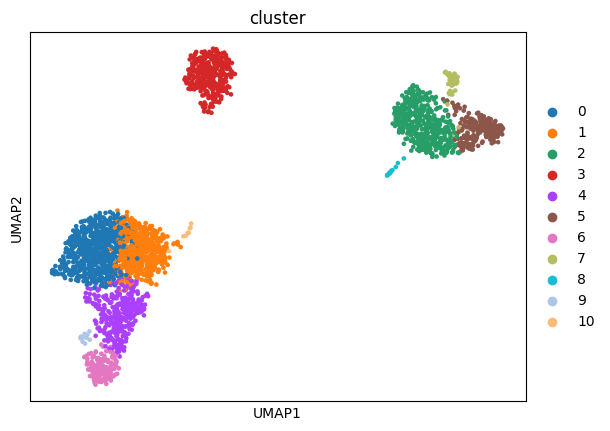

Saved plot to: ./figures/umap_pbmc_clusters.png


In [5]:
# %% UMAP + plot (and save image)
# Compute UMAP embedding (2D coordinates)
sc.tl.umap(adata)
# Plot cells, colored by cluster
sc.pl.umap(
    adata,
    color="cluster",
    save="_pbmc_clusters.png",
    show=True
)
print("Saved plot to: ./figures/umap_pbmc_clusters.png")

In [6]:
# %% Prepare X (features) and y (labels) for PyTorch
import numpy as np

# Use PCA representation as input features
X = adata.obsm["X_pca"]

# Convert cluster labels (strings) to integers
y = adata.obs["cluster"].astype(int).values

print("X shape:", X.shape)
print("y shape:", y.shape)
print("Unique labels:", np.unique(y))


X shape: (2700, 50)
y shape: (2700,)
Unique labels: [ 0  1  2  3  4  5  6  7  8  9 10]


In [7]:
# %% Train/test split + PyTorch DataLoader
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

# Split data (80% train, 20% test), keeping class distribution similar
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Convert to torch tensors
X_train_t = torch.from_numpy(X_train)
y_train_t = torch.from_numpy(y_train).long()
X_test_t = torch.from_numpy(X_test)
y_test_t = torch.from_numpy(y_test).long()

# Wrap tensors into datasets
train_ds = TensorDataset(X_train_t, y_train_t)
test_ds = TensorDataset(X_test_t, y_test_t)

# DataLoaders = iterate in batches
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False)

print("Train batches:", len(train_loader))
print("Test batches:", len(test_loader))
print("One batch X shape:", next(iter(train_loader))[0].shape)
print("One batch y shape:", next(iter(train_loader))[1].shape)


Train batches: 34
Test batches: 9
One batch X shape: torch.Size([64, 50])
One batch y shape: torch.Size([64])


In [8]:
# %% Simple PyTorch model + training loop (baseline)
import torch.nn as nn

# Model: a tiny neural net (50 -> 64 -> 11)
model = nn.Sequential(
    nn.Linear(X.shape[1], 64),
    nn.ReLU(),
    nn.Linear(64, len(np.unique(y)))
)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

def accuracy(loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for xb, yb in loader:
            logits = model(xb)
            preds = torch.argmax(logits, dim=1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)
    return correct / total

# Train for a few epochs
for epoch in range(1, 6):
    model.train()
    running_loss = 0.0

    for xb, yb in train_loader:
        optimizer.zero_grad()
        logits = model(xb)
        loss = loss_fn(logits, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_acc = accuracy(train_loader)
    test_acc = accuracy(test_loader)

    print(f"Epoch {epoch}: loss={running_loss/len(train_loader):.4f}  train_acc={train_acc:.3f}  test_acc={test_acc:.3f}")



Epoch 1: loss=1.9200  train_acc=0.735  test_acc=0.739
Epoch 2: loss=1.0743  train_acc=0.854  test_acc=0.833
Epoch 3: loss=0.6193  train_acc=0.896  test_acc=0.878
Epoch 4: loss=0.4069  train_acc=0.921  test_acc=0.913
Epoch 5: loss=0.3029  train_acc=0.929  test_acc=0.926


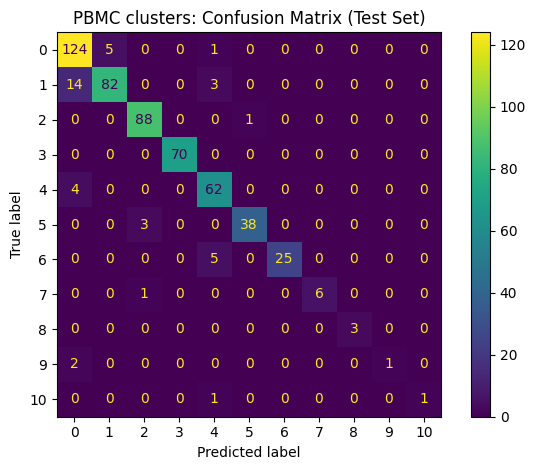

Saved: confusion_matrix.png


In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Collect predictions on test set
model.eval()
all_preds = []
all_true = []

with torch.no_grad():
    for xb, yb in test_loader:
        logits = model(xb)
        preds = torch.argmax(logits, dim=1)
        all_preds.append(preds.cpu())
        all_true.append(yb.cpu())

y_pred = torch.cat(all_preds).numpy()
y_true = torch.cat(all_true).numpy()

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(values_format="d")
plt.title("PBMC clusters: Confusion Matrix (Test Set)")
plt.tight_layout()

# Save in project folder
plt.savefig("figures/confusion_matrix.png", dpi=200)
plt.show()

print("Saved: confusion_matrix.png")


In [10]:
import os
import torch

os.makedirs("models", exist_ok=True)
model_path = "models/pbmc_cluster_classifier.pt"

torch.save(model.state_dict(), model_path)
print(f"Saved model weights to: {model_path}")


Saved model weights to: models/pbmc_cluster_classifier.pt


In [11]:
# %% Use HVG gene-expression as features (instead of PCA) + rebuild loaders
import numpy as np
import scipy.sparse as sp
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

# After HVG selection with subset=True, adata.X is (cells x 2000 HVGs)
X_hvg = adata.X

# Convert sparse -> dense (PBMC3k is small enough for this)
if sp.issparse(X_hvg):
    X_hvg = X_hvg.toarray()

X_hvg = X_hvg.astype(np.float32)
y_hvg = adata.obs["cluster"].astype(int).values

print("HVG X shape:", X_hvg.shape)   # should be (2700, 2000)
print("y shape:", y_hvg.shape)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_hvg, y_hvg, test_size=0.2, random_state=42, stratify=y_hvg
)

# Torch tensors
X_train_t = torch.from_numpy(X_train)
y_train_t = torch.from_numpy(y_train).long()
X_test_t = torch.from_numpy(X_test)
y_test_t = torch.from_numpy(y_test).long()

train_loader_hvg = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=64, shuffle=True)
test_loader_hvg = DataLoader(TensorDataset(X_test_t, y_test_t), batch_size=64, shuffle=False)

print("Train batches (HVG):", len(train_loader_hvg))
print("Test batches (HVG):", len(test_loader_hvg))



HVG X shape: (2700, 2000)
y shape: (2700,)
Train batches (HVG): 34
Test batches (HVG): 9


In [12]:
# %% Train PyTorch classifier on HVG features
import torch.nn as nn
import torch

n_features = X_hvg.shape[1]           # 2000
n_classes = len(np.unique(y_hvg))     # 11

model_hvg = nn.Sequential(
    nn.Linear(n_features, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, 64),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(64, n_classes),
)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_hvg.parameters(), lr=1e-3)

def accuracy_hvg(loader):
    model_hvg.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for xb, yb in loader:
            logits = model_hvg(xb)
            preds = torch.argmax(logits, dim=1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)
    return correct / total

for epoch in range(1, 6):
    model_hvg.train()
    running_loss = 0.0

    for xb, yb in train_loader_hvg:
        optimizer.zero_grad()
        logits = model_hvg(xb)
        loss = loss_fn(logits, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_acc = accuracy_hvg(train_loader_hvg)
    test_acc = accuracy_hvg(test_loader_hvg)

    print(f"[HVG] Epoch {epoch}: loss={running_loss/len(train_loader_hvg):.4f}  train_acc={train_acc:.3f}  test_acc={test_acc:.3f}")


[HVG] Epoch 1: loss=1.3339  train_acc=0.885  test_acc=0.830
[HVG] Epoch 2: loss=0.3038  train_acc=0.984  test_acc=0.898
[HVG] Epoch 3: loss=0.0958  train_acc=0.993  test_acc=0.904
[HVG] Epoch 4: loss=0.0452  train_acc=1.000  test_acc=0.898
[HVG] Epoch 5: loss=0.0214  train_acc=1.000  test_acc=0.907


In [13]:
# %% Save HVG model weights
import os
import torch

os.makedirs("models", exist_ok=True)
model_path_hvg = "models/pbmc_hvg_cluster_classifier.pt"

torch.save(model_hvg.state_dict(), model_path_hvg)
print(f"Saved HVG model weights to: {model_path_hvg}")


Saved HVG model weights to: models/pbmc_hvg_cluster_classifier.pt


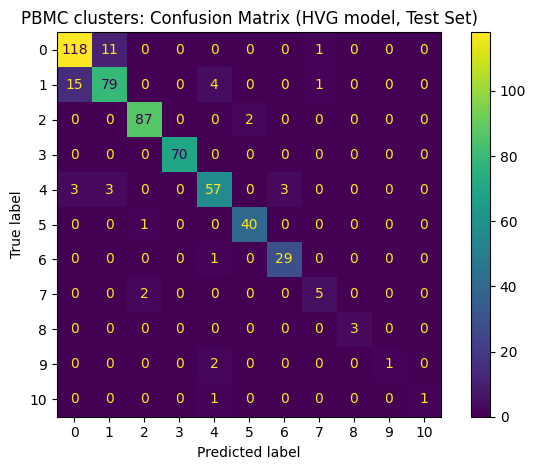

Saved: figures/confusion_matrix_hvg.png


In [14]:
# %% Confusion matrix for HVG model + save
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch

os.makedirs("figures", exist_ok=True)

# Predict on test set (HVG)
model_hvg.eval()
all_preds = []
all_true = []

with torch.no_grad():
    for xb, yb in test_loader_hvg:
        logits = model_hvg(xb)
        preds = torch.argmax(logits, dim=1)
        all_preds.append(preds.cpu())
        all_true.append(yb.cpu())

y_pred = torch.cat(all_preds).numpy()
y_true = torch.cat(all_true).numpy()

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(values_format="d")
plt.title("PBMC clusters: Confusion Matrix (HVG model, Test Set)")
plt.tight_layout()

plt.savefig("figures/confusion_matrix_hvg.png", dpi=200)
plt.show()

print("Saved: figures/confusion_matrix_hvg.png")

In [15]:
# %% Train HVG model with early stopping + save best checkpoint
import os
import copy
import torch
import torch.nn as nn

os.makedirs("models", exist_ok=True)

n_features = X_hvg.shape[1]
n_classes = len(np.unique(y_hvg))

model_hvg_es = nn.Sequential(
    nn.Linear(n_features, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, 64),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(64, n_classes),
)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_hvg_es.parameters(), lr=1e-3)

def acc(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for xb, yb in loader:
            logits = model(xb)
            preds = torch.argmax(logits, dim=1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)
    return correct / total

best_acc = -1.0
best_state = None
patience = 5
no_improve = 0
max_epochs = 50

for epoch in range(1, max_epochs + 1):
    model_hvg_es.train()
    running_loss = 0.0

    for xb, yb in train_loader_hvg:
        optimizer.zero_grad()
        logits = model_hvg_es(xb)
        loss = loss_fn(logits, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_acc = acc(model_hvg_es, train_loader_hvg)
    test_acc = acc(model_hvg_es, test_loader_hvg)

    print(f"[ES] Epoch {epoch}: loss={running_loss/len(train_loader_hvg):.4f}  train_acc={train_acc:.3f}  test_acc={test_acc:.3f}")

    # Early stopping logic (monitor test accuracy)
    if test_acc > best_acc + 1e-4:
        best_acc = test_acc
        best_state = copy.deepcopy(model_hvg_es.state_dict())
        no_improve = 0
    else:
        no_improve += 1
        if no_improve >= patience:
            print(f"[ES] Early stopping triggered. Best test_acc={best_acc:.3f}")
            break

# Save best checkpoint
best_path = "models/pbmc_hvg_classifier_earlystop_best.pt"
torch.save(best_state, best_path)
print(f"[ES] Saved best model to: {best_path}")

[ES] Epoch 1: loss=1.3595  train_acc=0.925  test_acc=0.867
[ES] Epoch 2: loss=0.3017  train_acc=0.982  test_acc=0.902
[ES] Epoch 3: loss=0.0895  train_acc=0.996  test_acc=0.906
[ES] Epoch 4: loss=0.0379  train_acc=1.000  test_acc=0.896
[ES] Epoch 5: loss=0.0171  train_acc=1.000  test_acc=0.906
[ES] Epoch 6: loss=0.0133  train_acc=1.000  test_acc=0.911
[ES] Epoch 7: loss=0.0099  train_acc=1.000  test_acc=0.900
[ES] Epoch 8: loss=0.0056  train_acc=1.000  test_acc=0.904
[ES] Epoch 9: loss=0.0078  train_acc=1.000  test_acc=0.893
[ES] Epoch 10: loss=0.0036  train_acc=1.000  test_acc=0.889
[ES] Epoch 11: loss=0.0026  train_acc=1.000  test_acc=0.891
[ES] Early stopping triggered. Best test_acc=0.911
[ES] Saved best model to: models/pbmc_hvg_classifier_earlystop_best.pt


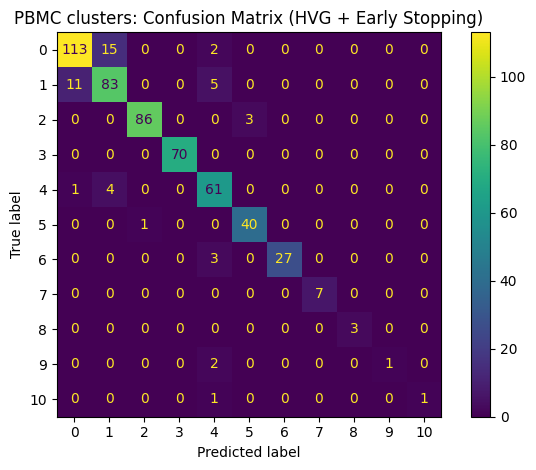

Saved: figures/confusion_matrix_hvg_earlystop.png


In [16]:
# %% Confusion matrix for early-stopped HVG model
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch

# Load best checkpoint into the model (safety step)
model_hvg_es.load_state_dict(
    torch.load("models/pbmc_hvg_classifier_earlystop_best.pt")
)
model_hvg_es.eval()

all_preds = []
all_true = []

with torch.no_grad():
    for xb, yb in test_loader_hvg:
        logits = model_hvg_es(xb)
        preds = torch.argmax(logits, dim=1)
        all_preds.append(preds.cpu())
        all_true.append(yb.cpu())

y_pred = torch.cat(all_preds).numpy()
y_true = torch.cat(all_true).numpy()

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(values_format="d")
plt.title("PBMC clusters: Confusion Matrix (HVG + Early Stopping)")
plt.tight_layout()

plt.savefig("figures/confusion_matrix_hvg_earlystop.png", dpi=200)
plt.show()

print("Saved: figures/confusion_matrix_hvg_earlystop.png")
